# The PIPELINE is in three parts:

## Train a classifier to recognize vehicles

a) Cell __ STEP 1 __  check the samples for cars and not cars, display one image from each set 
b) cell __ STEP 2 __  we extract the color  and the HOG features
        In this step we use the Histogram of Oriented Gradients for feature extraction and normalized

        # Read in each one by one
        # apply color conversion if other than 'RGB'
        # Apply bin_spatial() to get spatial color features
        # Apply color_hist() to get color histogram features
        # Append the new feature vector to the features list
        # Return list of feature vectors

    #Parameters to extract the features
    colorspace = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 9
    pix_per_cell = 8
    cell_per_block = 2
    hog_channel = 0

c) Cell __ STEP 3 __  Normalize the samples
    Divide the smplesinto test and training sets
    Apply the classifier SVM
    Try out the recognition on a single image
    Save the model and the scaler (generate 2 files)

## Roll the classification on a sliding-window  

Recognize vehicles on a video

## Reject false positives and apply on a video stream

Reject false positives using heat maps
Overlay lane detection from previous project4


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import cv2
import pickle
from random import randint

import time
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
import scipy as sc
from library_classifier import *




('vector cars is:', 1196)
('non cars is:', 1125)
('random cars_sample cars is:', 255)
('random nonnotcars_samplecars is:', 1065)
('Your function returned a count of', 1196, ' cars and', 1125, ' non-cars')
('of size: ', (64, 64, 3), ' and data type:', dtype('uint8'))


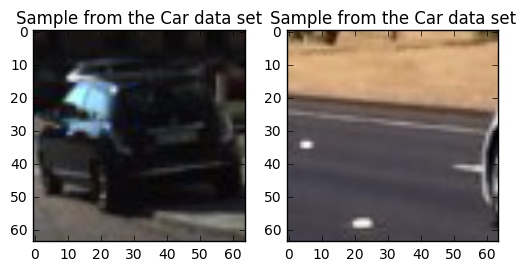

In [75]:
# __ STEP 1  __ Extracting the path of the two data sets: vehicles and non-vechicles
path_images_cars = glob.glob('vehicles_smallset/*/*.jpeg')
cars = []
notcars = []
for image in path_images_cars:
    cars.append(image)

path_images_notcars = glob.glob('non-vehicles_smallset/*/*.jpeg')
for image in path_images_notcars:
    notcars.append(image)

# Rendering one image from each set for testing    
cars_sample=randint(0,len(cars))
notcars_sample=randint(0, len(notcars))
print ("vector cars is:", len(cars))
print ("non cars is:", len(notcars))
print ("random cars_sample cars is:", cars_sample)
print ("random nonnotcars_samplecars is:", notcars_sample)



# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    example_img = mpimg.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = example_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = example_img.dtype
    # Return data_dict
    return data_dict
    
data_info = data_look(cars, notcars)

print('Your function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])

# Plot the examples
fig = plt.figure()
plt.subplot(121)
img = plt.imread(cars[cars_sample])
plt.imshow(img)
plt.title('Sample from the Car data set')
plt.subplot(122)
img = plt.imread(notcars[notcars_sample])
plt.imshow(img)
plt.title('Sample from the Car data set')
plt.show()
      

    

(5.81, 'Seconds to extract HOG features...')
('cars is length:', 1196)
('notcars is length', 1125)
('number of features', 1196)
(' number of features', 1125)


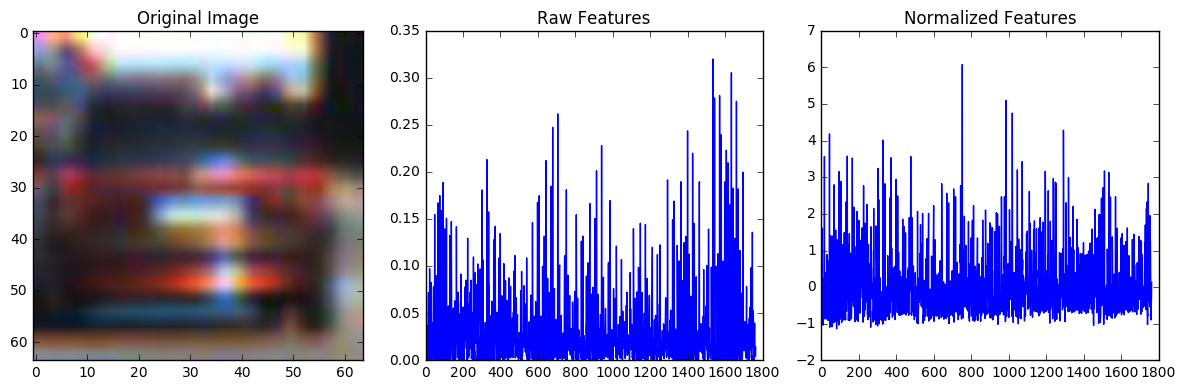

((1764,), (1764,), (1764,))


In [76]:
# Extractingthe features
# Cell __ STEP 2  __

import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.preprocessing import StandardScaler
import glob

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features

#Parameters to extract the features
colorspace = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 0 # Can be 0, 1, 2, or "ALL"


t=time.time() # counting time start
car_features = extract_features(cars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features = extract_features(notcars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
t2 = time.time() # counting time stop
print(round(t2-t, 2), 'Seconds to extract HOG features...')


print ("cars is length:",len(cars))
print ("notcars is length",len(notcars))
print ("number of features", len(car_features))
print (" number of features",len(notcar_features))

if len(car_features) > 0:
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    car_ind = np.random.randint(0, len(cars))
    # Plot an example of raw and scaled features
    fig = plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.imshow(mpimg.imread(cars[car_ind]))
    
    plt.title('Original Image')
    plt.subplot(132)
   
    plt.plot(X[car_ind])
    plt.title('Raw Features')
    
    plt.subplot(133)
    plt.plot(scaled_X[car_ind])
   
    plt.title('Normalized Features')
    #plt.show()
    fig.tight_layout()
    plt.show()
else: 
    print('Your function only returns empty feature vectors...')

print(notcar_features[2].shape, notcar_features[0].shape, notcar_features[1].shape)


In [7]:
# Cell __ STEP 3 __

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

# Use a linear SVC 
svc = LinearSVC()

# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('TRAIN Accuracy of SVC = ', round(svc.score(X_train, y_train), 4))
print('TEST Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

# Check the prediction time for a single sample
t=time.time()
n_predict = 20
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

# save the model to disk
filename = 'model_color_hog.sav'
pickle.dump(svc, open(filename, 'wb'))
filename = 'save_scaler.sav'
pickle.dump(X_scaler, open(filename, 'wb'))



NameError: name 'car_features' is not defined

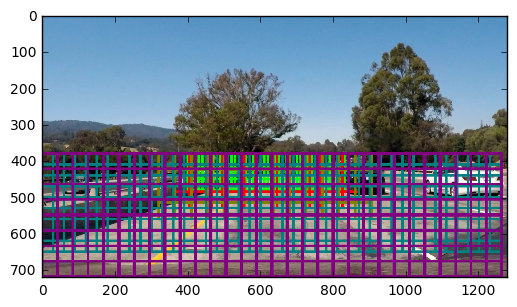

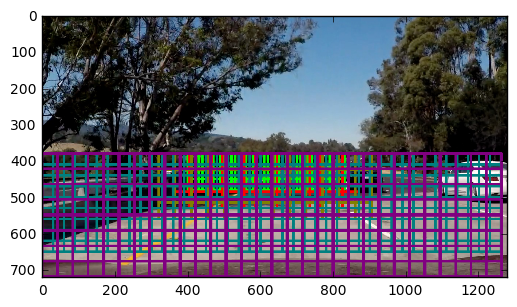

In [8]:
# Cell __STEP 4__ extracting windows froma  single image
from library_classifier import *
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# load SVM model
svc = pickle.load(open('model_color_hog.sav', 'rb'))

# load scaler
X_scaler = pickle.load(open('save_scaler.sav', 'rb'))

image_test1 = mpimg.imread('test1.jpg')
image_test5 = mpimg.imread('test5.jpg')
test_images = []
test_images.append(np.copy(image_test1))
test_images.append(np.copy(image_test5))

#defining regions of interest and size of boxes to look for recognitions
scales = [(40,40), (60,60), (90,90), (120,120), (170,170)]
overlaps = [0.25, 0.25, 0.5, 0.75, 0.75]
y_stops = [500, 550, 600, 650, None]
x_start_stops = [[400,850], [360,890], [320,930], [None, None], [None, None]]
colors = [(0,255,0), (255,0,0), (128,128,0), (0,128,128), (128,0,128)]

result_image = []
for image in test_images:
    possible_windows = np.copy(image)
    for scale, overlap, color, y_stop, x_start_stop in zip(scales, overlaps, colors, y_stops, x_start_stops):

        windows = slide_window(possible_windows, x_start_stop=x_start_stop, y_start_stop=[380,y_stop],
                                   xy_window=scale, xy_overlap=(overlap, overlap))

        possible_windows = draw_boxes(possible_windows, windows, color=color, thick=6) 

    result_image.append((np.copy(possible_windows)))

# Plot the test images
for i in range(len(result_image)):
    imgplot = plt.imshow(result_image[i])
    plt.show()
      


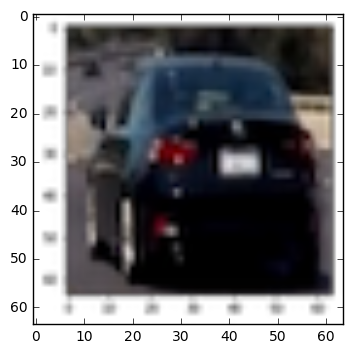

(' feature vector is of size', 2793)
64 64 4
('shape of that array is', (2793,))


ValueError: setting an array element with a sequence.

In [33]:
# In this step we try to identify using features the various cars in the image
### TODO: Tweak these parameters and see how the results change.
from library_classifier import *

color_space = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [400, 680] # Min and max in y to search in slide_window()

test_extracted_image = mpimg.imread('test_image.png')
plt.imshow(test_extracted_image)
plt.show()

features = single_img_features(test_extracted_image,color_space=color_space,
                            spatial_size=spatial_size, hist_bins=hist_bins,
                            orient=orient, pix_per_cell=pix_per_cell,
                            cell_per_block=cell_per_block,
                            hog_channel=hog_channel, spatial_feat=spatial_feat,
                            hist_feat=hist_feat, hog_feat=hog_feat)

print (" feature vector is of size", len(features))

height, width, channels = test_extracted_image.shape
print height, width, channels

#array_test= np.array(features)
l=len(features)
array_test = np.asarray(features)
print ("shape of that array is", array_test.shape)

test_features = X_scaler.transform(np.array(features).astype(np.float64).reshape(1, -1))
#prediction = svc.predict(test_features)
#print("testing the prediction", prediction)
"""
windows = slide_window(image_test1, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5))

hot_windows = search_windows(image_test1, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

plt.imshow(window_img)
"""